# Lab 5
## Machine Learning

### Importing packages

As usual we begin by importing the necessary packages and functions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

## Student Performance Dataset <a class="anchor" id="dataset"></a>

We will once again be working with the student performance dataset this week. More information on the dataset can be found here: https://archive.ics.uci.edu/dataset/320/student+performance.

First load in the dataset and check the data.

In [16]:
data = pd.read_csv("student-mat.csv", sep=";")
print(data)

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  ... famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3
0       GP   F   18       U     GT3       A     4     4   at_home   teacher  ...      4        3      4     1     1      3        6   5   6   6
1       GP   F   17       U     GT3       T     1     1   at_home     other  ...      5        3      3     1     1      3        4   5   5   6
2       GP   F   15       U     LE3       T     1     1   at_home     other  ...      4        3      2     2     3      3       10   7   8  10
3       GP   F   15       U     GT3       T     4     2    health  services  ...      3        2      2     1     1      5        2  15  14  15
4       GP   F   16       U     GT3       T     3     3     other     other  ...      4        3      2     1     2      5        4   6  10  10
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...  ...    ...      ...    ...   ...   ...    ...      ...  .. 

#### Test, Training, Validation Split

We are interested still in predicting G3, the students final scores, so this will be our y variable, and all other variables are our X. 

In [17]:
X = data.drop(['G1', 'G2', 'G3'], axis=1)
y = data['G3']

### Split data into training and test sets

As always we split the data into a training and test set, this time with an 80/20 split. As we are going to use cross-validation we don't have to specify a validation set.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We will be doing both regression and classification so we also store the binary variable denoting whether students passed or failed.

In [19]:
y_test_binary = y_test.apply(lambda x: 1 if x >= 10 else 0)
y_train_binary = y_train.apply(lambda x: 1 if x >= 10 else 0)

#### Pre-processing Categorical and Numerical Variables

As we have a mix of nominal, ordinal and numerical data we don't want to apply the same transformations to all of them. We can use the ColumnTransformer class to apply the appropriate transformations to each column.

You do not need to scale variables before using tree-based methods (e.g., decision trees, random forests, gradient boosting methods like XGBoost, LightGBM, and CatBoost). Tree-based models are scale-invariant because they split data based on feature thresholds rather than distance-based calculations. We *can* still scale variables if we want however, and indeed, doing so can have benifits for numerical stability in cases where values get very big.

In [20]:
categorical_features = ['school', 'sex','address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 
                        'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 
                        'internet', 'romantic']
numerical_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 
                      'goout', 'Dalc', 'Walc', 'health', 'absences']

# Preprocessors for numerical and categorical data
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output= False), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

#Use the preprocessor to transform the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Decision Trees

We start by fitting a very simple decision tree for the binary outcome. You can play around with the max_depth parameter and the plotting to get a sense of how decision trees are formed.

In [21]:
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train, y_train_binary)
dt_pred = dt_model.predict(X_test)

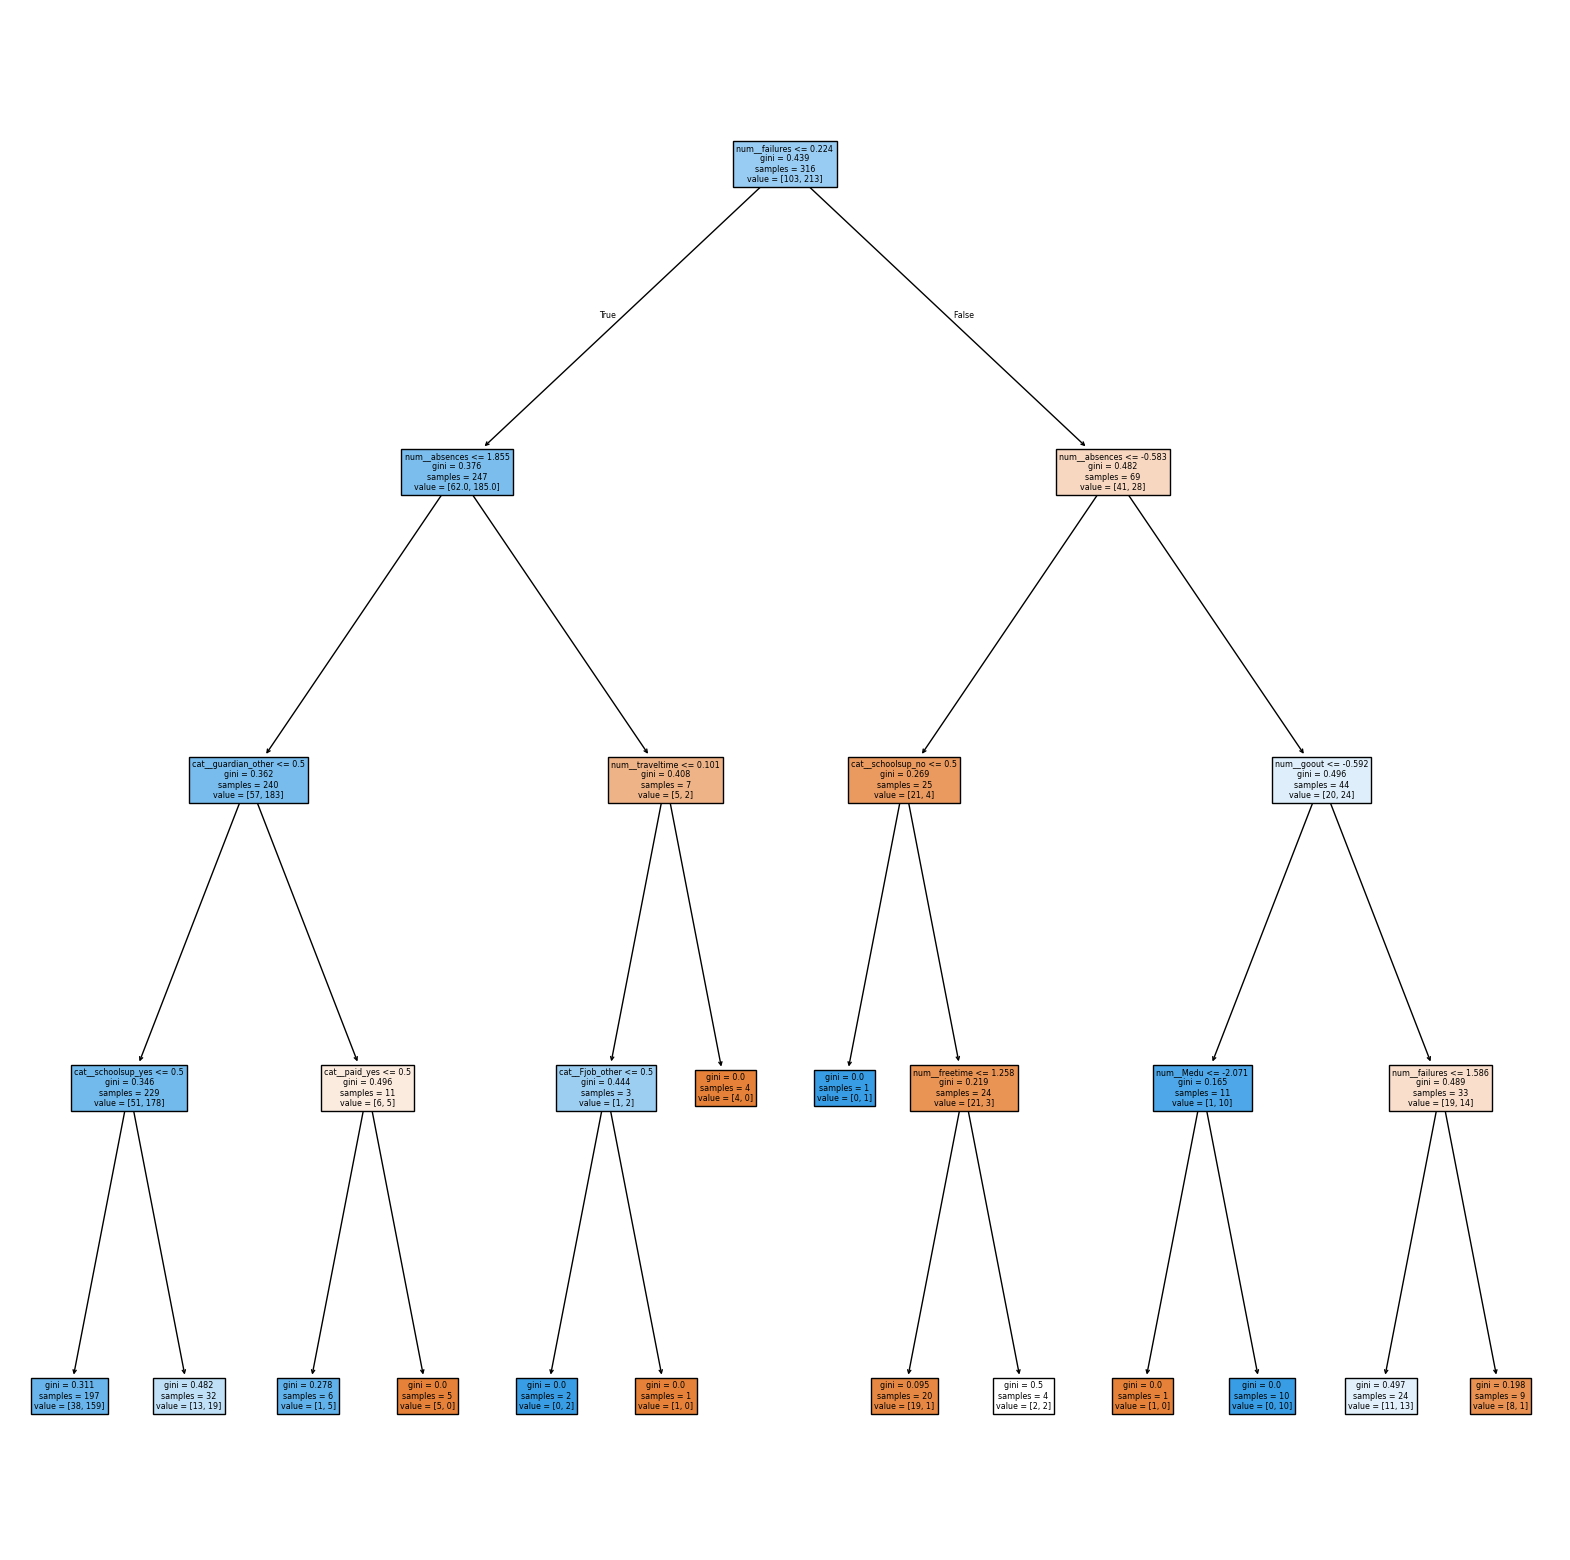

In [22]:
#Display the decision tree
plt.figure(figsize=(20,20))
plot_tree(dt_model, feature_names = preprocessor.get_feature_names_out(), filled=True)
plt.show()

Now we switch tracks to a Decision Tree Regressor. Each leaf node will now contain a continuous value, calculated as the average of the target values in that leaf. For each of the tree-based methods we consider they will have a Classifier and Regressor option.

In [23]:
dt_reg = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_reg.fit(X_train, y_train)
dt_reg_pred = dt_reg.predict(X_test)

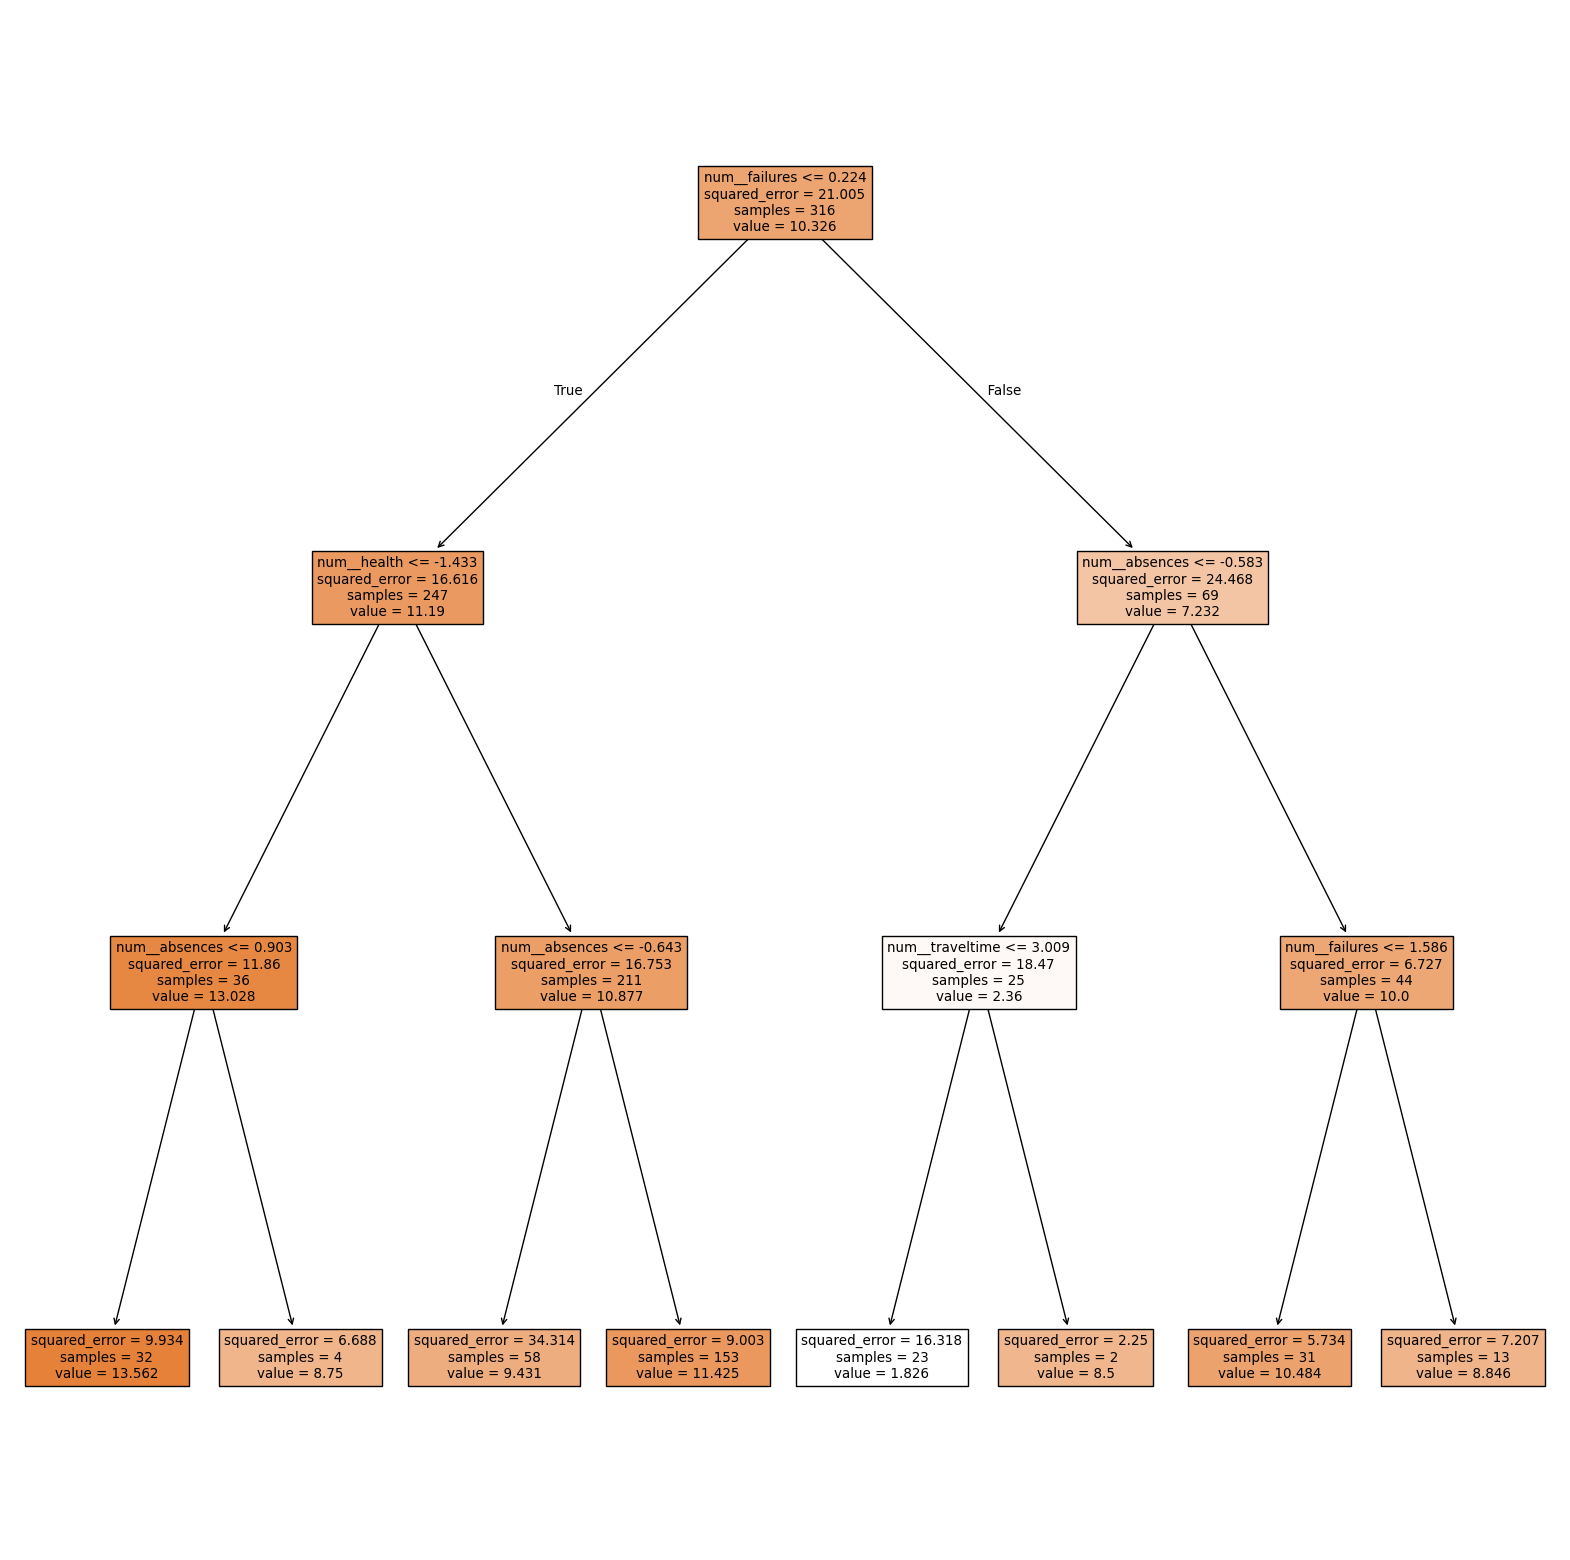

In [24]:
#Display the decision tree
plt.figure(figsize=(20,20))
plot_tree(dt_reg, feature_names=preprocessor.get_feature_names_out(), filled=True)
plt.show()

### Cross-Validation

Cross-validation is a method used to evaluate how well a machine learning model performs on unseen data. Instead of using just one training and test split, the data is divided into multiple parts (called "folds"). The model is trained on all but one of these folds and tested on the remaining one. This process is repeated multiple times, and the results are averaged to get a more reliable estimate of the model's performance.

We use the cross_val_score function for k-fold cross-validation as such: `cross_val_score(model_name, X_train, y_train, cv=k)`. The result will be a score for each fold which we can then average to get our overall estimate for the accuracy.

Use a 10 fold cross validation on our dt_model from above and print the mean score. In general the larger the dataset, the smaller the fold used as otherwise the fitting process can become much too time consuming.

In [36]:
dt_model_cv = cross_val_score(dt_model, X_train, y_train, cv=4)

print(f"mean score: {dt_model_cv.mean()}")
print(dt_model_cv)

mean score: 0.1867088607594937
[0.18987342 0.21518987 0.11392405 0.2278481 ]


C:\Users\felix\miniconda3\envs\ml2025\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Predict the test set results and calculate the accuracy for the dt_model, compare the two scores as an indication of how well the cross validation proceedure worked. You can also try changing k above to get an indication of the variability.

In [40]:
y_test_hat = dt_model.predict(X=X_test)

accuracy_score(y_test_binary, y_test_hat)

0.7088607594936709

An important hyperparameter for decision trees is the depth of the tree, which can be set using the max_depth parameter. This cuts the tree off after a certain depth has been reached, which can help prevent overfitting. We can use cross validation the same way we would have used a validation set to pick the optimal value for this hyperparameter.

The code below loops over 20 different depths from 1 to 21, calculating both the accuracy on the training set and 10-fold cross-validation accuracy see if you can understand the code and explain the output.

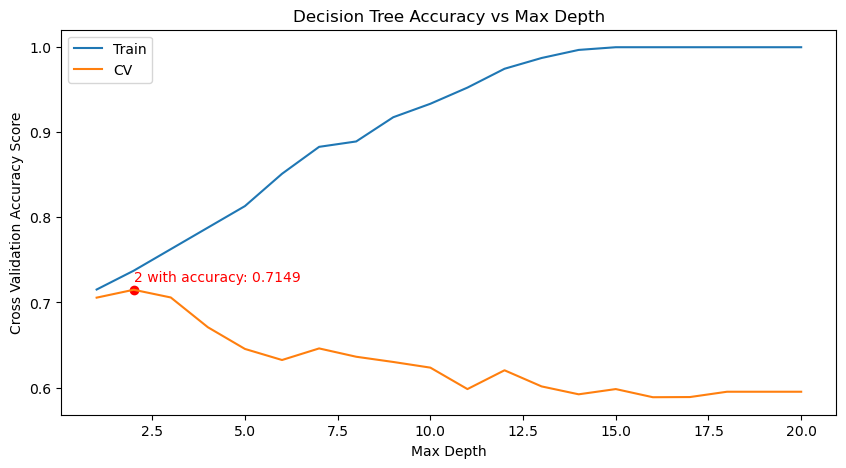

In [56]:
depths = np.arange(1, 21)
dt_train_scores = []
dt_model_cv_scores = []

for depth in depths:
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_train, y_train_binary)
    dt_train_pred = dt_model.predict(X_train)
    dt_train_scores.append(accuracy_score(y_train_binary, dt_train_pred))
    dt_model_cv_scores.append(np.mean(cross_val_score(dt_model, X_train, y_train_binary, cv=10)))
    
plt.figure(figsize=(10,5))
plt.plot(depths, dt_train_scores, label='Train')
plt.plot(depths, dt_model_cv_scores, label='CV')
plt.scatter(depths[dt_model_cv_scores.index(max(dt_model_cv_scores))], max(dt_model_cv_scores), color='red')
plt.text(depths[dt_model_cv_scores.index(max(dt_model_cv_scores))], max(dt_model_cv_scores)+.01, f'{depths[dt_model_cv_scores.index(max(dt_model_cv_scores))]} with accuracy: {round(max(dt_model_cv_scores), ndigits=4)}', color='red',)
plt.xlabel('Max Depth')
plt.ylabel('Cross Validation Accuracy Score')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.legend()

# Random Forests

Random Forest are an ensemble learning model which constructs multiple decision trees and combines their predictions to improve accuracy and reduce overfitting. It achieves robustness by training each tree on a random subset of the data and features, making it effective for both classification and regression tasks.

We train Random Forests using the funciton RandomForestRegressor() and RandomForestClassifier(). Fit a regression to our continuose outcome y_train and calculate the MSE and RMSE.

In [61]:
rf_reg = RandomForestRegressor(max_depth=4, random_state=42)
rf_reg.fit(X_train, y_train)
rf_reg_pred = dt_model.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, rf_reg_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, rf_reg_pred))}')


MSE: 120.9620253164557
RMSE: 10.998273742567772


### Grid Searches

The idea with a Grid Search is that the model tests each differwnt combination of the hyperparameters to find the best-performing combination based on cross-validation. This can be effective for finding optimal models, but very time and computationally expensive.

For the random forest Regressor we set up our grid to include the following hyper-parameters:

**n_estimators** - This is the number of trees in the forest. A higher number of usually leads to better performance (up to a certain point) but increases computation time.

**max_depth** - This is the maximum depth of each tree in the forest. Setting a maximum depth helps control overfitting. Deeper trees capture more patterns but risk overfitting, while shallower trees may underfit. None means nodes are expanded until all leaves are pure or contain fewer than min_samples_split samples.

**min_samples_split**: This controls the minimum number of samples required to split a node. A lower value (e.g., 2) allows trees to grow deeper and potentially overfit, while a higher value (e.g., 10) forces trees to be more constrained, reducing overfitting but potentially leading to underfitting.

In [62]:
# Grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)
cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5) #Here we perform a grid search with 5-fold cross validation
cv_rf.fit(X_train, y_train) # Fit the model to the training set - this will perform the grid search and find the model with the best hyper-parameters

# Mean cross-validated score of the best_estimator
print("Mean cross-validated score of the best_estimator:", cv_rf.best_score_)

# Print the best parameters
print("Best parameters:", cv_rf.best_params_)

# Refit the model with the best parameters on the entire training set
rf_model = cv_rf.best_estimator_
rf_pred = rf_model.predict(X_test)

#Calculating the accuracy
print("Best Random Forest Classifier")
print("Test Set MSE: ", mean_squared_error(y_test, rf_pred))

Mean cross-validated score of the best_estimator: 0.2794722280392616
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest Classifier
Test Set MSE:  14.238738275548148


# XGBoost

XGBoost is a fast, scalable, and regularized gradient boosting algorithm that excels at predictive modeling tasks, especially on structured data. It improves performance through optimized tree learning, parallelization, and built-in regularization to prevent overfitting.

See if you can initialise an XGBRegressor and perform a grid search with 5-fold cross validation. I have provided below a param_grid designed for tuning an XGBoost model, specifying a range of values for six key hyperparameters that control its behavior and performance. I have specifically made the list quite short for each hyperparameter to prevent fitting taking impractically long amounts of time.

The hyperparameters for XGBoost are as follows:

**max_depth:** Sets the maximum depth of each tree. Deeper trees can model more complex relationships but increase the risk of overfitting. Shallower trees improve generalization but may underfit.

**min_child_weight:** Defines the minimum sum of instance weights (Hessian) required to create a new node. Higher values make the model more conservative by preventing splits on small, less significant data groups, reducing overfitting.

**learning_rate (eta):** Controls the step size in updating weights after each boosting round. Lower values slow down learning but improve generalization, often requiring more trees (n_estimators) to reach optimal performance.

**n_estimators:** Specifies the number of boosting rounds (trees) in the ensemble. More trees generally improve performance but can lead to overfitting if not balanced with regularization.

**subsample:** Determines the fraction of training samples used in each boosting round. Values below 1.0 introduce randomness, reducing overfitting by making trees less dependent on specific data points.

**colsample_bytree:** Defines the fraction of features (columns) randomly selected for each tree. Using fewer features per tree increases diversity in the ensemble, helping prevent overfitting and improving robustness.

In [ ]:
param_grid = {
    'max_depth': [5, 7],  
    'min_child_weight': [1, 2, 3],  
    'learning_rate': [0.01, 0.05],  
    'n_estimators': [50, 100, 150],  
    'subsample': [0.75, 0.9],  
    'colsample_bytree': [0.75, 0.9]
}



### Feature Importance

A very useful feature of bagging-based tree models is that we can extract feature importances from the trained model.

Bonus: See if you can plot the importances which we extract in the  first line below. (Otherwise have a look at the graph in the solutions to see the importances).

In [ ]:
importances = xgb_optimized.feature_importances_

# Hint: We can get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()



# Bonus: LightGBM

In [ ]:
#import and use a LightGBM model
import lightgbm as lgb

X_train = pd.DataFrame(X_train, columns=feature_names) #For lightgbm, we need to convert the numpy array back to a pandas dataframe
X_test = pd.DataFrame(X_test, columns=feature_names) #For lightgbm, we need to convert the numpy array back to a pandas dataframe

lgb_model = lgb.LGBMRegressor(random_state=42, verbosity=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

#Predicting the test set results and calculating the accuracy
print("LightGBM Classifier")
print("Test Set MSE: ", mean_squared_error(y_test, lgb_pred))

**Tree Complexity** `num_leaves`: This parameter controls the maximum number of leaves each tree can have, directly affecting model complexity. A lower value results in simpler trees that generalize well, while a higher value allows for more detailed splits that may lead to overfitting.

**Step Size** `learning_rate`: The learning rate determines how much the model adjusts after each boosting iteration. A smaller learning rate slows training but improves generalization, whereas a higher learning rate speeds up convergence at the risk of overfitting.

**Number of Trees** `n_estimators`: This defines how many boosting rounds (trees) the model builds to minimize error. More trees generally improve accuracy but increase training time, while too few trees can lead to underfitting.

**Row Sampling** `subsample`: This parameter controls what fraction of the training data is randomly selected for each tree. Using a lower value (e.g., 0.8) introduces randomness that prevents overfitting, while using 1.0 means each tree is trained on the full dataset, which can improve performance but also increase overfitting risk.

**Feature Sampling** `colsample_bytree`: This parameter sets the fraction of features (columns) that are randomly selected for each tree during training. Lower values introduce diversity and reduce overfitting, while higher values use more features, potentially leading to stronger but less generalizable models.

**Minimum Data Per Leaf** `min_child_samples`: The minimum number of data points required in a leaf. Increasing it helps prevent overfitting by forcing larger leaves.

**L1 Regularization** `reg_alpha` Adds penalty for large coefficients (sparse solutions). Helps reduce overfitting.

**L2 Regularization** `reg_lambda` Similar to L1 but shrinks coefficients more smoothly. Helps control model complexity.

In [ ]:
param_grid = {
    'num_leaves': [20, 40],  
    'learning_rate': [0.01, 0.05],  
    'n_estimators': [50, 100],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 1],
    'reg_lambda': [0, 1],
    'min_child_samples': [20, 40]
}

lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
cv_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5) #Here we perform a grid search with 5-fold cross validation
cv_lgbm.fit(X_train, y_train) # Fit the model to the training set - this will perform the grid search and find the model with the best hyper-parameters

# Mean cross-validated score of the best_estimator
print("Mean cross-validated score of the best_estimator:", cv_lgbm.best_score_)
# Print the best parameters

print("Best parameters:", cv_lgbm.best_params_)
# Refit the model with the best parameters on the entire training set
lgb_model = cv_lgbm.best_estimator_
lgb_pred = lgb_model.predict(X_test)

#Calculating the accuracy
print("Best LightGBM Regressor")
print("Test Set MSE: ", mean_squared_error(y_test, lgb_pred))